In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os

In [8]:
image = cv.imread('sar_1_gray.jpg')
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
_, monochrom = cv.threshold(image_gray, 128, 255, cv.THRESH_BINARY)

with open('monochrom.txt', 'w') as file:
    for row in monochrom:
        line = ' '.join(str(pixel) for pixel in row)
        file.write(line + '\n')

print(f"Изображение сохранено в файл 'monochrom.txt', размер изображения: {monochrom.shape}")

Изображение сохранено в файл 'monochrom.txt', размер изображения: (400, 600)


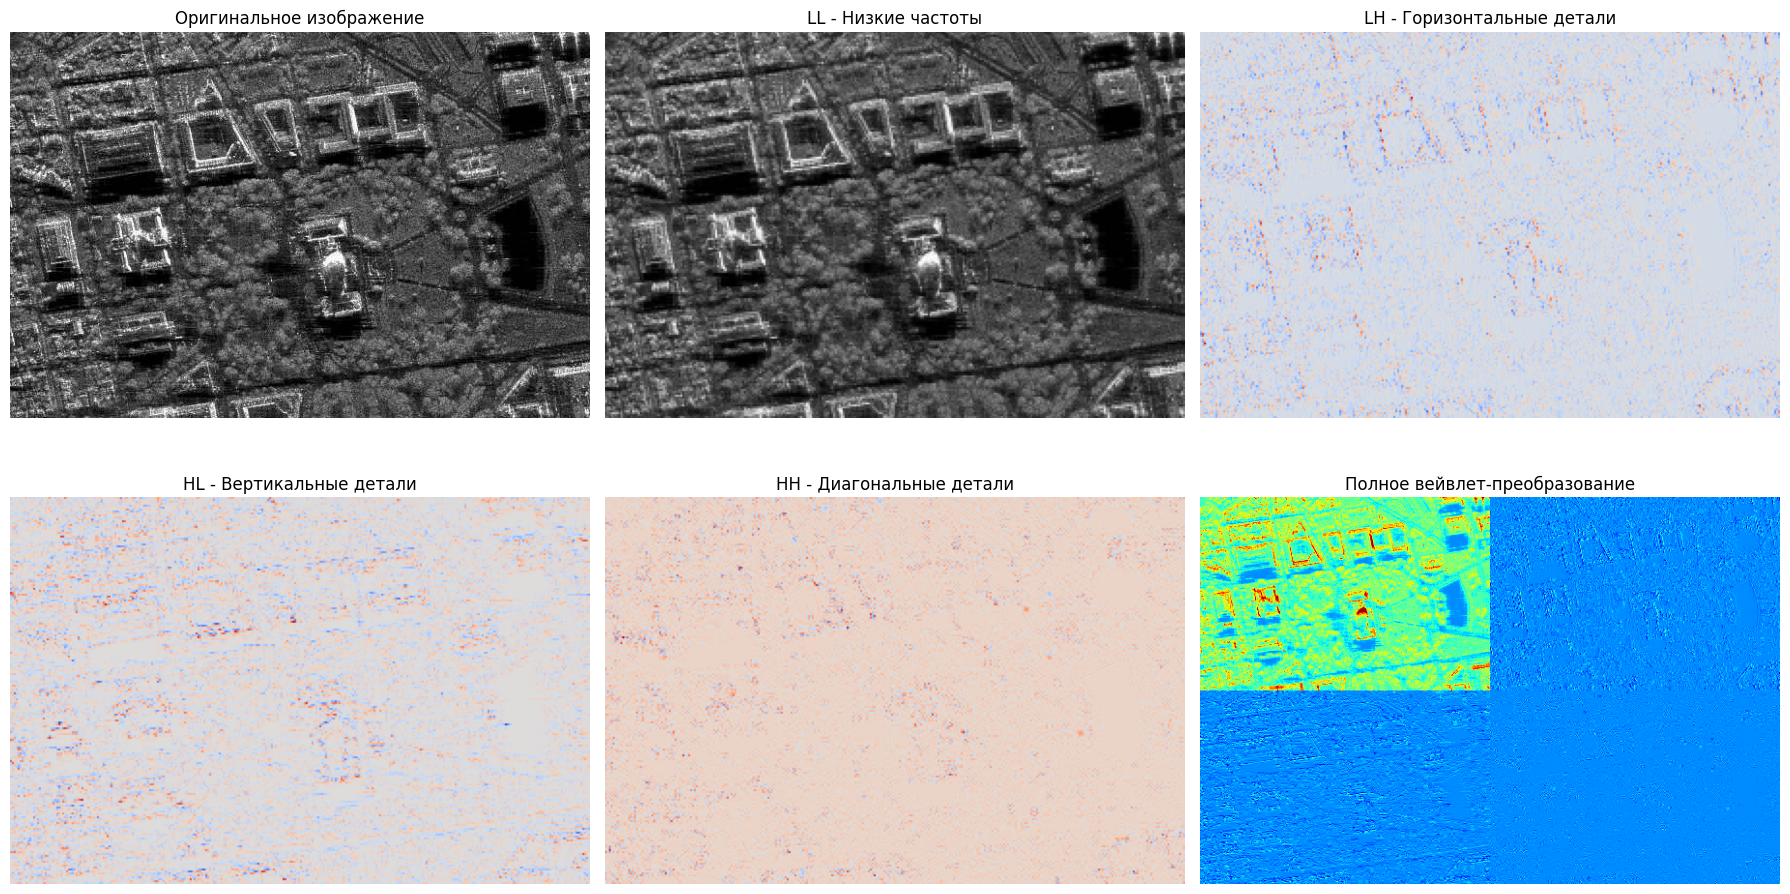

In [9]:
def haar_transform(image):
    image = image.astype(np.float32)
    h, w = image.shape
    temp = np.zeros_like(image)

    
    for i in range(h):
        for j in range(0, w, 2):
            if j + 1 < w:
                temp[i, j // 2] = (image[i, j] + image[i, j + 1]) / 2
                temp[i, j // 2 + w // 2] = (image[i, j] - image[i, j + 1]) / 2
            else:
                temp[i, j // 2] = image[i, j]

    result = np.zeros_like(temp)

   
    for j in range(w):
        for i in range(0, h, 2):
            if i + 1 < h:
                result[i // 2, j] = (temp[i, j] + temp[i + 1, j]) / 2
                result[i // 2 + h // 2, j] = (temp[i, j] - temp[i + 1, j]) / 2
            else:
                result[i // 2, j] = temp[i, j]

    ll = result[:h // 2, :w // 2]
    lh = result[:h // 2, w // 2:]
    hl = result[h // 2:, :w // 2]
    hh = result[h // 2:, w // 2:]

    return ll, lh, hl, hh, result

ll, lh, hl, hh, haar_result = haar_transform(image_gray)

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Оригинальное изображение'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(ll, cmap='gray'); plt.title('LL - Низкие частоты'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(lh, cmap='coolwarm'); plt.title('LH - Горизонтальные детали'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(hl, cmap='coolwarm'); plt.title('HL - Вертикальные детали'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(hh, cmap='coolwarm'); plt.title('HH - Диагональные детали'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(haar_result, cmap='jet'); plt.title('Полное вейвлет-преобразование'); plt.axis('off')
plt.tight_layout()
plt.show()

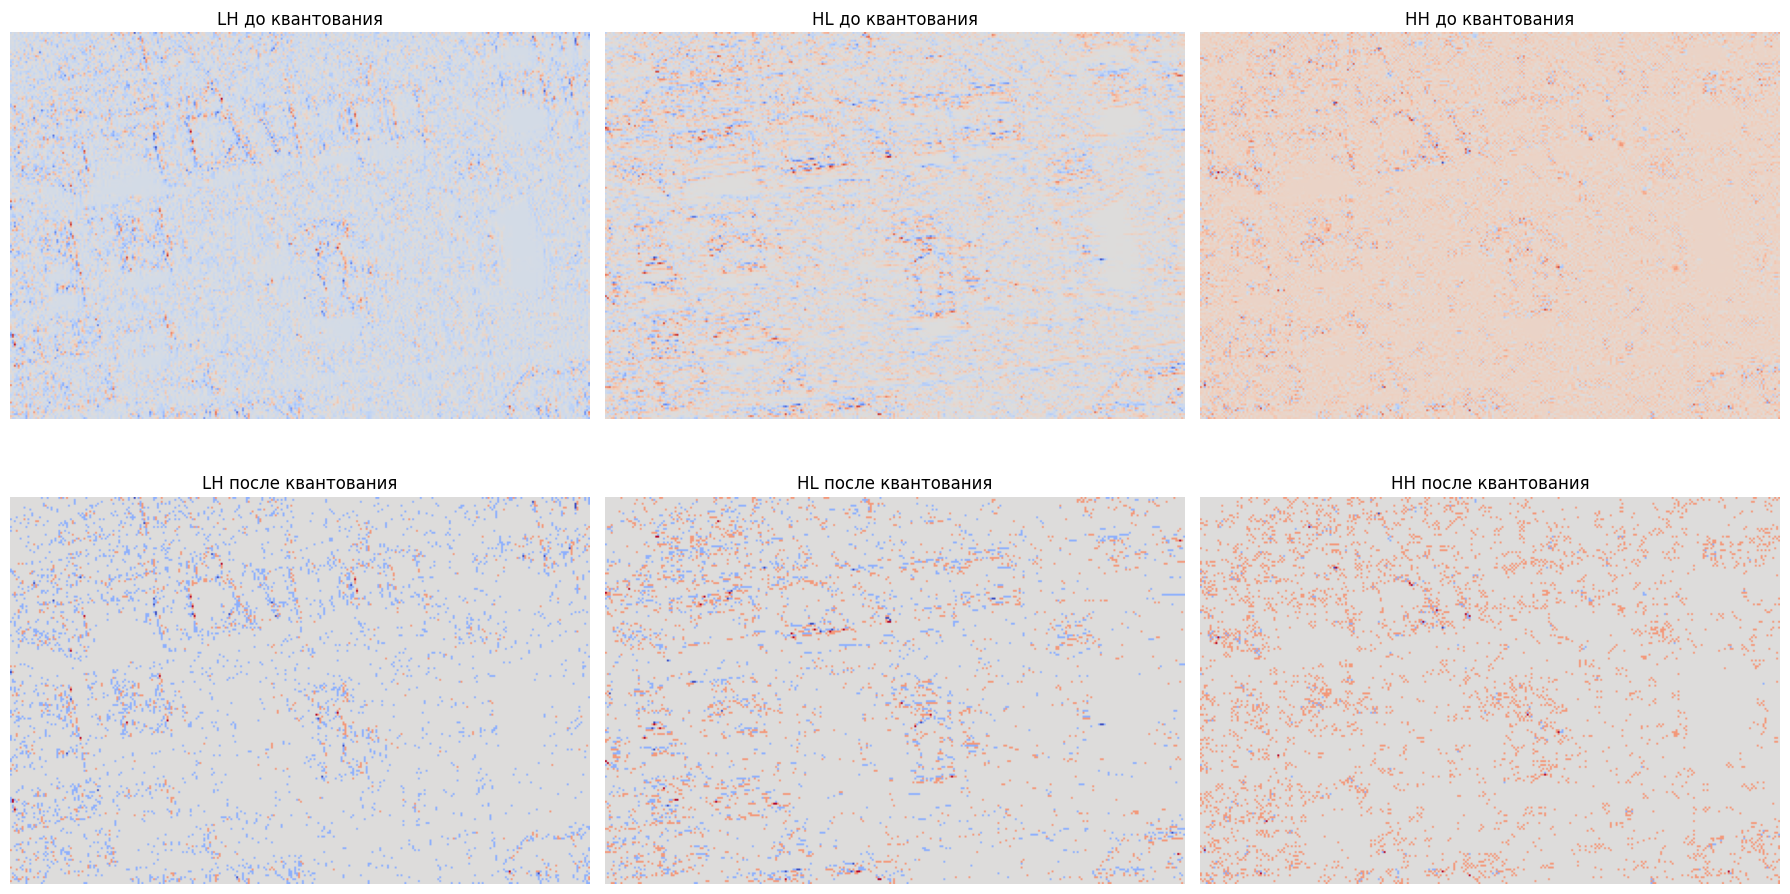

In [10]:
def quantize(coeffs, n_quants):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants if max_val != min_val else 1
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

def dequantize(quantized, min_val, step):
    return min_val + quantized * step

num_quants = 4
lh_q, lh_min, lh_step = quantize(lh, num_quants)
hl_q, hl_min, hl_step = quantize(hl, num_quants)
hh_q, hh_min, hh_step = quantize(hh, num_quants)

lh_restored = dequantize(lh_q, lh_min, lh_step)
hl_restored = dequantize(hl_q, hl_min, hl_step)
hh_restored = dequantize(hh_q, hh_min, hh_step)

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1); plt.imshow(lh, cmap='coolwarm'); plt.title('LH до квантования'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(hl, cmap='coolwarm'); plt.title('HL до квантования'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(hh, cmap='coolwarm'); plt.title('HH до квантования'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(lh_restored, cmap='coolwarm'); plt.title('LH после квантования'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(hl_restored, cmap='coolwarm'); plt.title('HL после квантования'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(hh_restored, cmap='coolwarm'); plt.title('HH после квантования'); plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
def run_length_encode(data):
    flat = data.flatten()
    encoded = []
    count = 1
    for i in range(1, len(flat)):
        if flat[i] == flat[i - 1]:
            count += 1
        else:
            encoded.append((flat[i - 1], count))
            count = 1
    encoded.append((flat[-1], count))
    return encoded

lh_rle = run_length_encode(lh_q)
hl_rle = run_length_encode(hl_q)
hh_rle = run_length_encode(hh_q)

with open('haar.txt', 'w') as file:
    np.savetxt(file, ll, fmt='%d')
    file.write('\n')
    components = [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]
    for name, data in components:
        file.write(f'=== {name} ===\n')
        for value, count in data:
            file.write(f"{value} {count}\n")
        file.write('\n')

print("Компоненты сохранены в файл 'haar.txt'")

Компоненты сохранены в файл 'haar.txt'


In [12]:
with open('monochrom.txt', 'r') as f:
    original_size = len(f.read().encode('utf-8'))
with open('haar.txt', 'r') as f:
    compressed_size = len(f.read().encode('utf-8'))

print(f"\nХранение монохромного изображения: {original_size} байт")
print(f"После преобразования Хаара и RLE-сжатия: {compressed_size} байт")
print(f"Сжали примерно в {original_size / compressed_size:.2f} раз")


Хранение монохромного изображения: 528542 байт
После преобразования Хаара и RLE-сжатия: 290132 байт
Сжали примерно в 1.82 раз
